# MORAL TEXT ANALYSIS OF POLITICAL CANDIDATES' TWEETS

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from time import time
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# ---
pd.set_option('display.max_columns', 150)
sns.set()
# ---

def clean_text(text):
    """
    Custom function to clean text from social media or political speeches.
    """
    # Text preprocessing: 
    # 1) Extract the text and transform it into lowercase
    clean_text = text.lower()
    
    # 2) Removing punctuation to get the transformed frequency properly after 
    # splitting by white spaces
    clean_text = re.sub(r'[^\w\s#@]', '', clean_text)
    
    # 3) Remove links from the raw text to avoid counting it as an additional word:
    clean_text = re.sub(r'https\w+', '', clean_text)
    
    # 4) Remove remaining whitespaces:
    clean_text = clean_text.strip()
    
    # 5) Transform more than two spaces, newlines and tabs into just one space:
    clean_text = re.sub(r'\s{2,}|\n|\t', ' ', clean_text)
    
    return clean_text

def compare_diffs_plot(dataframe, text_type, figheight = 8,
                       relative = True, word_freq = 100, return_dataset = False,
                       save_fig = False):
    """
    Get a dataframe with counts of moral values and each word, and generate 
    a plot of the differences in frequencies of use of moral foundations.
    ---
    dataframe: pd.DataFrame; The pandas DataFrame of counts to be used
    text_type: str; either "tweets" or "speeches". Used for the plot
    figheight: int; set figure height
    relative: bool; if True, it displays relative frequencies
    word_freq: int; if the measures are relative, it determines the frequency
        (e.g., per 1000 words if word_freq = 1000)
    return_dataset: bool; returns the dataset with the grouped foundations
    save_fig: bool; saves the figure
    """
    
    # Create a grouped moral foundation (both vice and virtue word counts are included)
    grouped_foundations_df = dataframe.copy()

    # Create a grouped moral foundation (both vice and virtue word counts are included)
    foundations = list(mfd_dict_esp.keys())
    core_foundations = []
    for foundation_vv in foundations:
        foundation = foundation_vv.split(".")[0]
        if foundation not in core_foundations:
            core_foundations.append(foundation)
        if foundation in grouped_foundations_df.columns:
            grouped_foundations_df[foundation] += grouped_foundations_df[foundation_vv]
        else:
            grouped_foundations_df[foundation] = grouped_foundations_df[foundation_vv]
    
    # We reorder the foundations to create a properly ordered plot:
    reordered_foundations = core_foundations[::-1]
    
    # Create a long dataframe to plot differences between parties:
    diff_df = grouped_foundations_df[["party", "n_words"] + reordered_foundations].copy()
    
    # Optional: Control for the length of each audio (i.e., compare relative frequencies)
    if relative:
        diff_df[reordered_foundations] = diff_df[reordered_foundations].apply(lambda x: x / (2 * diff_df["n_words"]))
        
        # Show the count per frequency of words (like per 1000 words):
        diff_df[reordered_foundations] = diff_df[reordered_foundations] * word_freq
        
    diff_df = diff_df.drop(["n_words"], axis = 1)
    
    # Return the dataset instead of a plot if that was specified
    if return_dataset:
        return diff_df
    
    # Turn the dataframe into a long format:
    diff_long = pd.melt(diff_df, id_vars = "party", value_vars = reordered_foundations)
    
    # Capitalize variable names for the legend:
    diff_long.variable = diff_long.variable.str.capitalize()
    
    # Generate plot:
    sns.set_style("whitegrid")
    font = {'family' : 'serif'}
    plt.rc('font', **font)
    
    # plt.show()
    g = sns.relplot(x = "party", y = "value", style = "variable", hue = "variable", 
                    kind = "line", palette = "gist_ncar", 
                    height = figheight, aspect = 1.5, data = diff_long.iloc[::-1])
    
    if relative:
        title = f"Relative mentions of moral foundations per party - {text_type.capitalize()}"
    else:
        title = f"Mentions of moral foundations per party - {text_type.capitalize()}"
        
    plt.title(title, size = 18, fontweight = "bold")
        
    plt.xlabel("Party", size = 15)
    if relative:
        plt.ylabel(f"Average mentions of each foundation per {word_freq} words", size = 15)
    else:
        plt.ylabel("Average mentions of each foundation per text", size = 15)
    
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    
    new_title = "Foundation"
    g._legend.set_title(new_title)
    
    
    plt.setp(g._legend.get_title(), fontsize = 12)
    plt.setp(g._legend.get_texts(), fontsize = 12)
    
    txt = "Source: Author's own elaboration\nwith data collected through the Twitter API"
    plt.figtext(0.6, -0.02, txt, wrap = True,
                horizontalalignment = 'left', fontsize = 11)
    
    plt.show();
    
    # Save figure
    if save_fig:
        g.savefig(f"plots/all_foundations_{text_type}.jpeg")
    
def clean_rows(rows):
    """
    Cleans rows so that parties are ordered in the Tukey intervals plots from right
    to left.
    """

    rows_to_reverse = [8, 3, 9, 6, 1, 4, 5]
    custom_order = [6, 9, 3, 8, 4, 7, 1, 0, 2, 5]
    

    def reverse_row(row):
        """
        Reverses the order and signs of a row in the Tukey interval.
        """
        new_row = []
        
        # Switch party names order:
        new_row.append(row[1])
        new_row.append(row[0])
        
        # Append mean diff, lower and upper with negative signs:
        new_row.append(- row[2])
        new_row.append(row[3])
        
        # Swap order of upper and lower after switching their signs:
        new_row.append(- row[5])
        new_row.append(- row[4])
        
        return new_row

    rows = [reverse_row(rows[row_id]) if row_id in rows_to_reverse else rows[row_id] for row_id in range(len(rows))]
    rows = [rows[row_order] for row_order in custom_order]
    
    return rows

In [2]:
# Load moral foundations dictionary in Spanish:
with open("dictionaries/final_mfd_dict_stems.pickle", "rb") as handle:
    mfd_dict_esp = pickle.load(handle)

---

## 1 - DATA LOADING

In [3]:
tweets_df = pd.read_csv("../data/tweets_df.csv")
tweets_df

,party,type,screen_name,user_id,name,status_id,created_at,text,status_url,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,media_type,quoted_status_id,quoted_user_id,quoted_screen_name,quoted_name,quoted_text,quoted_created_at,quoted_favorite_count,quoted_retweet_count,retweet_status_id,retweet_user_id,retweet_screen_name,retweet_name,retweet_favorite_count,retweet_retweet_count,followers_count,has_https,has_video
0,VOX,candidate,Santi_ABASCAL,260788584,Santiago Abascal 🇪🇸,1192938088672170000,2019-11-08T22:52:58Z,Impresionante cierre de campaña de VOX. Una mu...,https://twitter.com/Santi_ABASCAL/status/11929...,NaN,NaN,NaN,False,False,10925,3740,161,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,692558,True,True
1,VOX,candidate,Santi_ABASCAL,260788584,Santiago Abascal 🇪🇸,1192933989180420000,2019-11-08T22:36:41Z,Qué grandes profesionales tiene RTVE a la hora...,https://twitter.com/Santi_ABASCAL/status/11929...,NaN,NaN,NaN,False,False,24052,7999,733,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,692558,True,False
2,VOX,candidate,Santi_ABASCAL,260788584,Santiago Abascal 🇪🇸,1192933559255870000,2019-11-08T22:34:58Z,DATOS asistencia actos FIN DE CAMPAÑA partidos...,https://twitter.com/Santi_ABASCAL/status/11929...,NaN,NaN,NaN,False,True,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.192923e+18,3.344531e+09,Puntual24H,El Puntual 24H,4047.0,1682.0,692558,False,False
3,VOX,candidate,Santi_ABASCAL,260788584,Santiago Abascal 🇪🇸,1192928916173930000,2019-11-08T22:16:31Z,MADRID. La Plaza de Colón de Madrid ha acogido...,https://twitter.com/Santi_ABASCAL/status/11929...,1.192562e+18,260788584.0,Santi_ABASCAL,False,False,1559,555,18,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,692558,True,False
4,VOX,candidate,Santi_ABASCAL,260788584,Santiago Abascal 🇪🇸,1192921331429510000,2019-11-08T21:46:23Z,MADRID. Cierre de campaña en la Plaza de Colón...,https://twitter.com/Santi_ABASCAL/status/11929...,1.192580e+18,260788584.0,Santi_ABASCAL,False,False,3575,1330,50,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,692558,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,PODEMOS,party,PODEMOS,2288138575,PODEMOS,1191447353376550000,2019-11-04T20:09:19Z,Las cosas importantes de la vida nunca salen a...,https://twitter.com/PODEMOS/status/11914473533...,NaN,NaN,NaN,False,True,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.191446e+18,6.182273e+07,joanmena,🔻Joan Mena,143.0,63.0,1531167,True,False
2844,PODEMOS,party,PODEMOS,2288138575,PODEMOS,1191445946963500000,2019-11-04T20:03:44Z,Ya está todo preparado para el #DebateElectora...,https://twitter.com/PODEMOS/status/11914459469...,NaN,NaN,NaN,False,False,246,154,4,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1531167,True,True
2845,PODEMOS,party,PODEMOS,2288138575,PODEMOS,1191442719605960000,2019-11-04T19:50:54Z,🚖 @Pablo_Iglesias_ llega al #DebateElectoral e...,https://twitter.com/PODEMOS/status/11914427196...,NaN,NaN,NaN,False,False,2438,981,58,303,photo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1531167,True,True
2846,PODEMOS,party,PODEMOS,2288138575,PODEMOS,1191437590651650000,2019-11-04T19:30:32Z,La Fiscalía investiga al jefe de Vox en Andalu...,https://twitter.com/PODEMOS/status/11914375906...,NaN,NaN,NaN,False,True,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.191436e+18,3.013089e+08,RubenSanchezTW,Rubén Sánchez,2207.0,1830.0,1531167,True,False


## 2 - EDA

In [4]:
print("The number of tweets per party is:\n", tweets_df.party.value_counts())

The number of tweets per party is:
 PODEMOS    659
PP         583
PSOE       579
CS         540
VOX        487
Name: party, dtype: int64


## 3 - TEXT ANALYSIS USING THE MORAL FOUNDATIONS DICTIONARY IN SPANISH

Create a DataFrame that we will populate while analyzing tweets:

In [5]:
moral_df = tweets_df.loc[:, ["status_id", "created_at", 
                             "party", "screen_name", 
                             "type", "text"]].copy()

The part that takes longer to run is the creation of all columns, once they have been created it is faster:

In [6]:
start_time = time()

# Clean text: 
moral_df["clean_text"] = moral_df.text.apply(lambda x: clean_text(x))

# Count the number of words on the clean text
moral_df["n_words"] = moral_df.clean_text.apply(lambda x: int(len(x.split(" "))))

# Initialize all columns with zeros (start with foundations):
for foundation in mfd_dict_esp:
        moral_df[foundation] = 0
        
for words in mfd_dict_esp.values():
    for word in words:
        moral_df[word] = 0

# Loop: Count words belonging to the dictionary in each text:
for row in range(moral_df.shape[0]):
    
    clean_text = moral_df.loc[row, "clean_text"]
        
    # Loop through all words to count the number of instances in which they appear
    for foundation, words in mfd_dict_esp.items():
        
        for word in words:
            n_matches = moral_df.loc[row, word]
            
            # See if the word has not appared yet in the search
            # (to avoid counting twice the same word)
            if moral_df.loc[row, word] == 0:
                # We perform a regex search of our word on the text and 
                # add the number of words that matched
                n_matches = len(re.findall(word, clean_text))
                moral_df.loc[row, word] = n_matches

            moral_df.loc[row, foundation] += n_matches
            
    if row % 100 == 0:
        print(f'{row} / {moral_df.shape[0]}')

print(f'{time() - start_time} seconds of execution.')

0 / 2848
100 / 2848
200 / 2848
300 / 2848
400 / 2848
500 / 2848
600 / 2848
700 / 2848
800 / 2848
900 / 2848
1000 / 2848
1100 / 2848
1200 / 2848
1300 / 2848
1400 / 2848
1500 / 2848
1600 / 2848
1700 / 2848
1800 / 2848
1900 / 2848
2000 / 2848
2100 / 2848
2200 / 2848
2300 / 2848
2400 / 2848
2500 / 2848
2600 / 2848
2700 / 2848
2800 / 2848
1610.736034154892 seconds of execution.


In [8]:
# Save file
#moral_df.to_csv("../data/clean/counts_text.csv", index = False)

## 4 - COMPARE DIFFERENCES BETWEEN GROUPS

In [3]:
moral_df = pd.read_csv("../data/clean/counts_text.csv")

### Graphical differences using standard deviations:

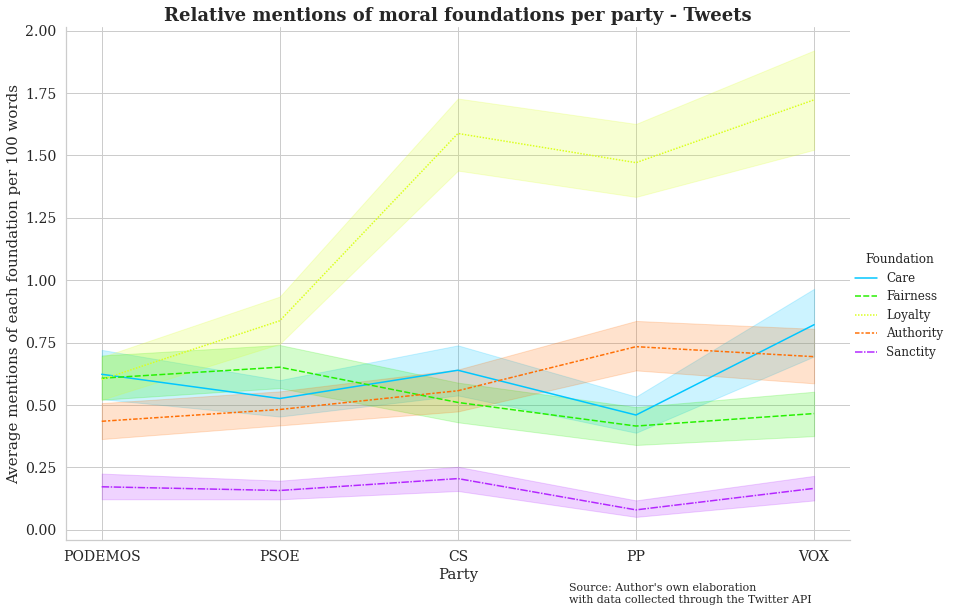

In [4]:
# Plot and save figure
compare_diffs_plot(moral_df, "tweets", save_fig = True)

Results change somewhat more than in speeches (especially taking into account the drop in sanctity of the popular party, which is more associated with religion), but the trends are essentially the same.

- Tukey intervals

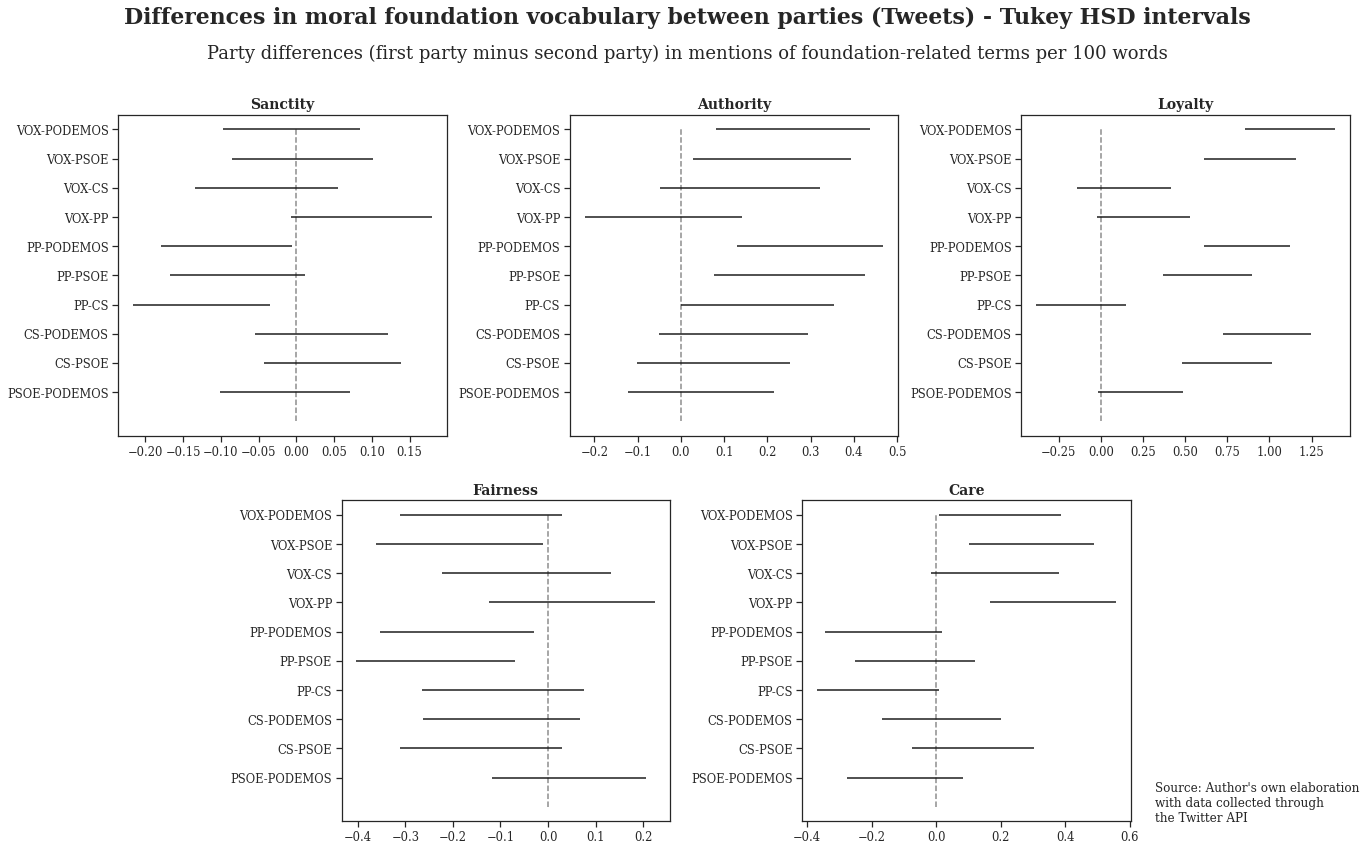

In [29]:
sns.set_style("ticks")
font = {'family' : 'serif'}
plt.rc('font', **font)

core_foundations = ['sanctity', 'authority', 'loyalty', 'fairness', 'care']
foundations_df = compare_diffs_plot(moral_df, "texts", return_dataset = True)

fig, axes = plt.subplots(2, 3, sharex = False, sharey = False, figsize = (20, 13))

text_type = "tweets"

# Create subplots only for 5 plots, eliminate the 6th one:
axes[1][2].set_visible(False)

go_right = 0.04
go_left = 0.02
go_up = -0.02

axes[0][0].set_position([0.125 - go_left, 0.5368181818181819 + go_up, 0.228, 0.343])
axes[0][1].set_position([0.3985294117647059 + go_right - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[0][2].set_position([0.6720588235294118 + (go_right * 2) - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[1][0].set_position([0.24 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])
axes[1][1].set_position([0.56 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])

# Set title and subtitle:
fig.text(s = f'Differences in moral foundation vocabulary between parties ({text_type.capitalize()}) - Tukey HSD intervals\n',
         x = 0.5, y = 0.95, fontsize = 22, ha = 'center', va = 'center', fontweight = "bold")

fig.text(s = 'Party differences (first party minus second party) in mentions of foundation-related terms per 100 words', x = 0.5, y = 0.925,
         fontsize = 18, ha = 'center', va = 'center')

for found_id in range(len(core_foundations)):
    col_nr = found_id
    # Determine the ax to plot
    if found_id <= 2:
        ax = axes[0][found_id]
        
    else:
        ax = axes[1][found_id - 3]
        
    # Calculate Tukey differences between groups and plot them
    foundation = core_foundations[found_id]
    tukey_comp = pairwise_tukeyhsd(endog  = foundations_df[foundation], 
                                   groups = foundations_df["party"],
                                   alpha  = 0.05)
    rows = clean_rows(tukey_comp.summary().data[1:])[::-1]
    ax.set_title(f'{foundation.capitalize()}', loc = 'center', 
                 fontsize = 14, fontweight = "bold")
    ax.hlines(range(len(rows)), [-row[5] for row in rows], [-row[4] for row in rows], color = 'k')
    ax.vlines(0, - 1, len(rows) - 1, linestyles = 'dashed', color = 'k', alpha = 0.5)
    
    # Format axes
    ax.set_yticks(range(len(rows)))
    ax.set_yticklabels([f'{x[0]}-{x[1]}' for x in rows])
    ax.xaxis.set_label(f'{foundation.capitalize()} mentions per 100 words')
    
    ax.yaxis.set_tick_params(labelsize = 11.5)
    ax.xaxis.set_tick_params(labelsize = 11.5)
    
# Set caption:
txt = "Source: Author's own elaboration\nwith data collected through\nthe Twitter API"
fig.text(0.825, 0.125, txt, fontsize = 12,
         ha = 'left', va = 'center')
    

    
plt.show();

fig.savefig(f'plots/tukey_intervals_{text_type}.jpeg')


### CHECK SENSITIVITY OF THE RESULTS:

- Check for sensitive words (graphical level with standard deviations):

In [9]:
# Here we create a function that generates the same dataframe, excluding the stem
# (or words) that we have inputted. It allows to make sensitivity checks:
low_sensitive_words = [r"\blegal", r"\bcoali", r"\bsegur"]

doubtful_meaning = [r"\bluch"]

highly_sensitive_words = [r"\bespañ", r"\bconstituci", r"\bpaís", r"\bpact"]



In [10]:
sens_words = low_sensitive_words + doubtful_meaning + highly_sensitive_words

new_df = moral_df.copy()
eliminations = {}
for word in sens_words:
    eliminations[word] = []
    
    # Find in which foundations it appears:
    for foundation, terms in mfd_dict_esp.items():
        if word in terms:
            eliminations[word].append(foundation)
            
            print(foundation)
            
    # Finally, substract those values from the foundations to which it belongs:
    for foundation in eliminations[word]:
        new_df[foundation] -= new_df[word]
    new_df.drop([word], axis = 1)

fairness.virtue
loyalty.virtue
care.virtue
care.vice
loyalty.virtue
fairness.virtue
authority.virtue
loyalty.virtue
authority.virtue


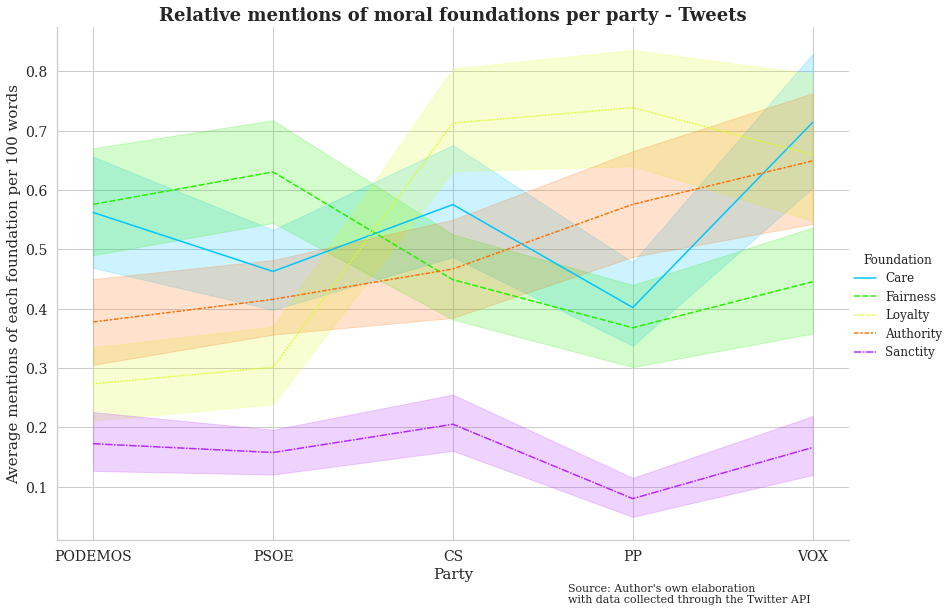

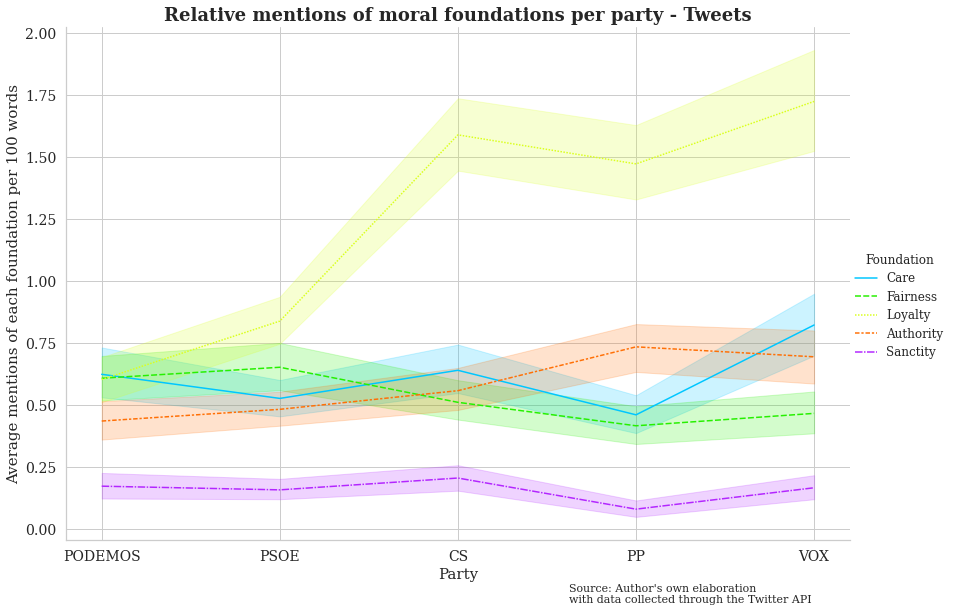

In [12]:
compare_diffs_plot(new_df, "tweets")
compare_diffs_plot(moral_df, "tweets")

Results are not sensitive to the elimination of certain common words, the patterns are the same (even if the standard deviations might change a lot).

- Check sensitivity of the results with Tukey intervals:

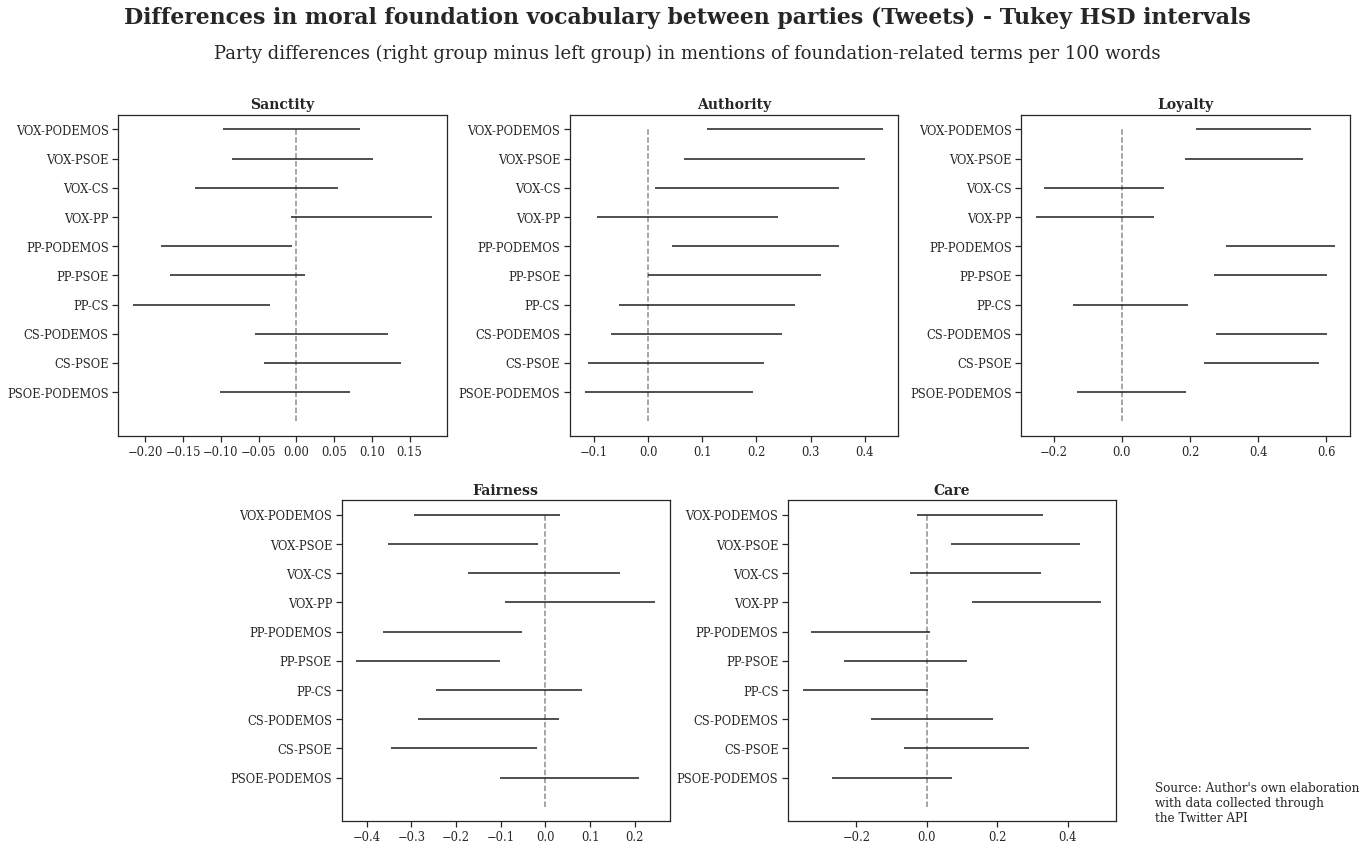

In [18]:
sns.set_style("ticks")
font = {'family' : 'serif'}
plt.rc('font', **font)

core_foundations = ['sanctity', 'authority', 'loyalty', 'fairness', 'care']
foundations_df = compare_diffs_plot(new_df, "texts", return_dataset = True)

fig, axes = plt.subplots(2, 3, sharex = False, sharey = False, figsize = (20, 13))

text_type = "tweets"

# Create subplots only for 5 plots, eliminate the 6th one:
axes[1][2].set_visible(False)

go_right = 0.04
go_left = 0.02
go_up = -0.02

axes[0][0].set_position([0.125 - go_left, 0.5368181818181819 + go_up, 0.228, 0.343])
axes[0][1].set_position([0.3985294117647059 + go_right - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[0][2].set_position([0.6720588235294118 + (go_right * 2) - go_left, 0.5368181818181819 + go_up,0.228,0.343])
axes[1][0].set_position([0.24 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])
axes[1][1].set_position([0.55 + go_right - go_left, 0.125 + go_up, 0.228, 0.343])

# Set title and subtitle:
fig.text(s = f'Differences in moral foundation vocabulary between parties ({text_type.capitalize()}) - Tukey HSD intervals\n',
         x = 0.5, y = 0.95, fontsize = 22, ha = 'center', va = 'center', fontweight = "bold")

fig.text(s = 'Party differences (right group minus left group) in mentions of foundation-related terms per 100 words', x = 0.5, y = 0.925,
         fontsize = 18, ha = 'center', va = 'center')

for found_id in range(len(core_foundations)):
    col_nr = found_id
    # Determine the ax to plot
    if found_id <= 2:
        ax = axes[0][found_id]
        
    else:
        ax = axes[1][found_id - 3]
        
    # Calculate Tukey differences between groups and plot them
    foundation = core_foundations[found_id]
    tukey_comp = pairwise_tukeyhsd(endog  = foundations_df[foundation], 
                                   groups = foundations_df["party"],
                                   alpha  = 0.05)
    rows = clean_rows(tukey_comp.summary().data[1:])[::-1]
    ax.set_title(f'{foundation.capitalize()}', loc = 'center', 
                 fontsize = 14, fontweight = "bold")
    ax.hlines(range(len(rows)), [-row[5] for row in rows], [-row[4] for row in rows], color = 'k')
    ax.vlines(0, - 1, len(rows) - 1, linestyles = 'dashed', color = 'k', alpha = 0.5)
    
    # Format axes
    ax.set_yticks(range(len(rows)))
    ax.set_yticklabels([f'{x[0]}-{x[1]}' for x in rows])
    ax.xaxis.set_label(f'{foundation.capitalize()} mentions per 100 words')
    
    ax.yaxis.set_tick_params(labelsize = 11.5)
    ax.xaxis.set_tick_params(labelsize = 11.5)
    
# Set caption:
txt = "Source: Author's own elaboration\nwith data collected through\nthe Twitter API"
fig.text(0.825, 0.125, txt, fontsize = 12,
         ha = 'left', va = 'center')
    

    
plt.show();

The main results of the analysis on **tweets** are not sensitive to the exclusion of dangerous words:

    1) VOX, PP, and Cs use more the loyalty foundation than left parties (PODEMOS, PSOE)
    2) Right parties (VOX, PP) use more the authority foundation than left parties (PODEMOS, PSOE)
    3) There are no big differences either in terms of fairness or care. Fairness is used more by left parties than right parties (except for PODEMOS-VOX). Care is equal between all parties except for VOX, which uses it way more than the two big parties (PP and PSOE).
    4) There is no evidence for supporting the use of more sanctity words by right parties.